In [2]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import numpy as np
plt.rcParams.update({'font.family':'serif'})

In [3]:
class ThresholdSwitch():
    R_off: float = 5e10
    R_on: float = 3e4
    V_th: float = 0.45
    V_hold: float = 0.05
    distribs: bool = False
    V_th_dist: float = V_th
    V_hold_dist: float = V_hold
    V_th_std: float = 0.03
    V_hold_std: float = 0.01

    def __init__(self,  R_off = R_off, R_on = R_on, V_th = V_th, V_hold = V_hold) -> None:
        self.R_off = R_off
        self.R_on = R_on
        self.V_th = V_th
        self.V_hold = V_hold
        self.state = 'off'

    def params_distibs(self, distribs = distribs, V_th_std = V_th_std, V_hold_std = V_hold_std) -> None:
        self.distribs = distribs
        self.V_th_std = V_th_std
        self.V_hold_std = V_hold_std

    def get_resistance(self, voltage: float) -> float:
        if (self.state == 'off') and ((voltage) < self.V_th):
            return self.R_off
        elif (self.state == 'off') and ((voltage) > self.V_th):
            self.state = 'on'
            if self.distribs == True:
                self.V_th = np.random.normal(loc = self.V_th_dist, scale = self.V_th_std)
            return self.R_on
        elif (self.state == 'on') and ((voltage) > self.V_hold):
            return self.R_on
        elif (self.state == 'on') and ((voltage) < self.V_hold):
            self.state = 'off'
            if self.distribs == True:
                self.V_hold = np.random.normal(loc = self.V_hold_dist, scale = self.V_hold_std)
            return self.R_off

In [4]:
class ExtendedLIF():
    I_inj: float = 5e-7
    C_m: float = 3e-10
    R_r: float = 1e6
    V_c_init: float = 0

    def __init__(self, ts: ThresholdSwitch, I_inj = I_inj, R_r = R_r, C_m = C_m) -> None:
        self.ts = ts
        self.I_inj = I_inj
        self.R_r = R_r
        self.C_m = C_m

    def initial_conditions(self, V_c_init = V_c_init) -> None:
        self.V_c_init = V_c_init

    def calculate(self, time_interval: float = 0.001, dots: int = 100000) -> tuple:
        self.R_ts = [self.ts.get_resistance(self.V_c_init)]
        self.V_c = [self.V_c_init]
        time_array = np.linspace(0, time_interval, dots)
        delta_t = time_array[1] - time_array[0]
        for i in range(1, dots):
            self.V_c.append((self.I_inj - self.V_c[i - 1] / self.R_ts[i - 1]) * (delta_t / self.C_m) + self.V_c[i - 1])
            self.R_ts.append(self.ts.get_resistance(self.V_c[i]))
        return time_array, self.V_c, self.R_ts

In [43]:
ts = ThresholdSwitch()
ts.params_distibs(distribs=True)
ex_lif = ExtendedLIF(ts=ts, C_m = 1.5e-7)
time, voltage, resistance = ex_lif.calculate(time_interval=0.5)

Text(0.5, 0, 'Время, с')

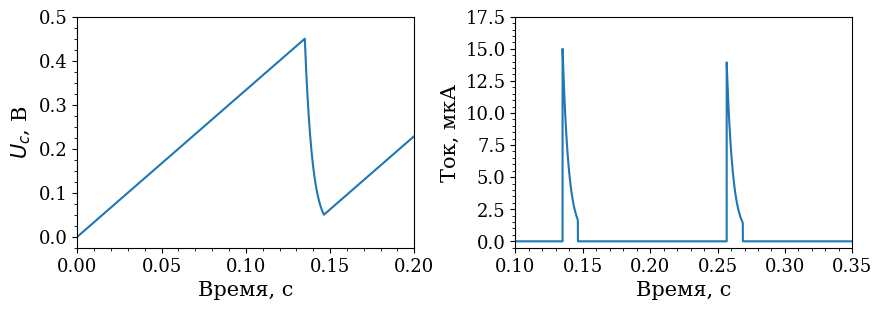

In [67]:
fig = plt.figure(figsize=(10, 3))
gs = GridSpec(ncols=2, nrows=1, figure=fig)
plt.rcParams.update({'font.family':'serif'})
ax_1 = fig.add_subplot(gs[0])
ax_2 = fig.add_subplot(gs[1])

gs.update(wspace=0.3, hspace = 0)

ax_1.plot(np.array(time), np.array(voltage))
ax_1.set_xlim([0, 0.2])
ax_1.set_ylim([-0.025, 0.5])
ax_1.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax_1.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))
ax_1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax_1.yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
ax_1.tick_params(labelsize = 13)
ax_1.set_ylabel(r'$U_c$, В', size = 15)
ax_1.set_xlabel('Время, с', size = 15)

ax_2.plot(np.array(time), np.array(voltage) / np.array(resistance) * 1e6)
ax_2.set_xlim([0.10, 0.35])
ax_2.set_ylim([-0.5, 17.5])
ax_2.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax_2.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))
ax_2.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
ax_2.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax_2.tick_params(labelsize = 13)
ax_2.set_ylabel('Ток, мкА', size = 15)
ax_2.set_xlabel('Время, с', size = 15)

In [68]:
delta_t = time[1] - time[0]
total_consumption = np.sum(delta_t * np.array(voltage) ** 2 / resistance)
n_of_spikes = 0
for i in range(len(resistance) - 1):
    if resistance[i+1] > resistance[i]:
        n_of_spikes += 1

total_consumption / n_of_spikes * 1e6

0.015123826352096375